# Project 21: Impact evaluation code

### 0. Import all the libraries needed.

In [1]:
import numpy # for math
import pandas # for data compilation in a comprehensive format
from sklearn.model_selection import train_test_split # for splitting data into training and test sets
from sklearn import svm # for predictive classification of the results into success of sessions or failure
from sklearn import linear_model # for predictive classification using regression
from sklearn.model_selection import cross_validate # for cross-validation of data to avoid overfitting the model
from matplotlib import pyplot # for data visualization x1
import seaborn # for data visualization x2
from scipy import stats # for normal approximation of the true shape of data distribution

## I. Data generation.

### 1. Generate fake data for testing the model in the absence of real data.

In [2]:
def generate_data(sample_size):

    # 1. Generate random demographics:
    
    # a) Randomly generate 0 if male, 1 if female, with equal probabilities;
    gender = numpy.random.choice([0, 1], size = sample_size)
    
    # b) Generate 0 if student with 70% probability and 1 if worker with 30% probability;
    occupation = numpy.random.choice([0, 1], p = [0.7, 0.3], size = sample_size)
    
    # c) Get one sample from the normal distribution:
    #    i. Mean at 20 years and with standard deviation of 1 year if student, so 95% of samples will be 18-22 years.
    #    ii. Mean at 27 years and with standard deviation of 3 years if worker, so 95% of samples - 21-33 years.
    age = [int(numpy.random.normal(20, 1, 1)) if i == 0 else int(numpy.random.normal(27, 3, 1)) for i in occupation]
    
    # 2. Compile demographics into one list of dependent variables for further model fitting.
    x = [[gender[i], occupation[i], age[i]] for i in range(sample_size)]
    
    # 3. Generate pre-sessions level of confidence (ranging 1-5) in 1 skill as the variable dependent on the demographics,
    # with addition of randomness.
    # Here I am assuming gender does not influence level of confidence, occupation and age influence it barely.
    # In the context of generating fake data, high proportion of randomness can also be seen as modelling
    # some other factors that influence the result and that I did not account for.
    pre_y = [int(occupation[i]*0.1 + age[i]/12 + 2*numpy.random.rand()) for i in range(sample_size)] # some random formula
    
    # 4. Generate post-sessions level of confidence (ranging 1-5) in 1 skill as the variable dependent on the pre-sessions level,
    # with addition of randomness.
    # In this case, the whole increase in the level of confidence due to participation in sessions
    # is due to a randomness as a mix of unaccounted for components.
    # The randomness component is one sample from a normal distribution with mean 1.5 and standard deviation 0.5,
    # meaning randomness contributes +0.5-2.5 change in 95% of cases, with average change being +1.5.
    post_y = [int(pre_y[i] + numpy.random.normal(1.5, 0.5, 1)) for i in range(sample_size)]
    
    # 5. Calculate the effect of the sessions as the change in the level of confidence.
    effect_y = [[post_y[i] - pre_y[i]] for i in range(sample_size)]
    
    # 6. Return data in the format that is appropriate for the modelling.
    return numpy.array(gender), numpy.array(occupation), numpy.array(age), numpy.array(x), numpy.array(pre_y), numpy.array(post_y), numpy.array(effect_y).flatten()

gender, occupation, age, x, pre_y, post_y, effect_y = generate_data(150)

### 2. Observe generated data.

In [3]:
gender 

array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0])

In [4]:
occupation

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [5]:
age

array([29, 30, 35, 27, 28, 18, 19, 32, 24, 18, 18, 19, 27, 19, 19, 22, 21,
       30, 18, 19, 26, 24, 26, 27, 18, 18, 20, 18, 19, 33, 19, 19, 19, 20,
       21, 21, 25, 19, 20, 27, 21, 26, 20, 22, 19, 30, 20, 18, 29, 19, 20,
       17, 28, 20, 19, 20, 19, 20, 21, 24, 26, 21, 21, 24, 26, 21, 27, 19,
       19, 27, 19, 20, 20, 19, 29, 19, 17, 20, 20, 18, 29, 20, 20, 18, 18,
       19, 21, 18, 30, 18, 19, 19, 20, 30, 19, 26, 20, 18, 24, 19, 28, 17,
       19, 18, 20, 20, 18, 20, 19, 20, 30, 20, 25, 20, 20, 19, 19, 21, 20,
       20, 21, 20, 25, 21, 19, 26, 17, 21, 23, 20, 19, 27, 26, 21, 20, 20,
       19, 26, 19, 20, 20, 18, 18, 20, 27, 20, 20, 19, 23, 20])

In [6]:
x

array([[ 0,  1, 29],
       [ 0,  1, 30],
       [ 1,  1, 35],
       [ 1,  1, 27],
       [ 0,  1, 28],
       [ 0,  0, 18],
       [ 0,  0, 19],
       [ 1,  1, 32],
       [ 0,  1, 24],
       [ 1,  0, 18],
       [ 0,  0, 18],
       [ 1,  0, 19],
       [ 0,  1, 27],
       [ 1,  0, 19],
       [ 0,  0, 19],
       [ 0,  0, 22],
       [ 1,  0, 21],
       [ 0,  1, 30],
       [ 0,  0, 18],
       [ 1,  0, 19],
       [ 1,  1, 26],
       [ 0,  1, 24],
       [ 0,  1, 26],
       [ 0,  1, 27],
       [ 1,  0, 18],
       [ 0,  0, 18],
       [ 1,  0, 20],
       [ 1,  0, 18],
       [ 1,  0, 19],
       [ 0,  1, 33],
       [ 0,  0, 19],
       [ 0,  0, 19],
       [ 0,  0, 19],
       [ 0,  0, 20],
       [ 0,  0, 21],
       [ 1,  0, 21],
       [ 0,  1, 25],
       [ 1,  0, 19],
       [ 0,  0, 20],
       [ 0,  1, 27],
       [ 0,  0, 21],
       [ 0,  1, 26],
       [ 1,  0, 20],
       [ 1,  0, 22],
       [ 0,  0, 19],
       [ 0,  1, 30],
       [ 1,  0, 20],
       [ 1,  

In [7]:
pre_y

array([2, 4, 4, 4, 3, 2, 2, 3, 3, 2, 1, 1, 3, 3, 2, 3, 2, 2, 3, 2, 4, 3,
       3, 3, 2, 2, 2, 1, 2, 4, 1, 3, 1, 3, 3, 2, 4, 1, 3, 3, 3, 3, 1, 2,
       2, 3, 2, 1, 4, 2, 3, 3, 3, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2,
       4, 3, 3, 3, 2, 2, 3, 3, 4, 2, 3, 3, 2, 2, 3, 3, 3, 2, 1, 2, 3, 3,
       3, 3, 1, 1, 2, 4, 3, 3, 3, 2, 2, 3, 2, 1, 3, 3, 1, 3, 2, 3, 2, 2,
       4, 2, 3, 3, 1, 2, 1, 3, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 2, 2, 2, 3, 2, 1, 2, 2, 1, 3, 3, 2, 2, 3, 3, 1])

In [8]:
post_y

array([3, 5, 6, 6, 4, 3, 3, 4, 4, 2, 2, 2, 4, 4, 3, 4, 3, 3, 4, 3, 5, 5,
       5, 4, 3, 3, 3, 2, 2, 6, 1, 4, 2, 4, 4, 2, 4, 2, 4, 4, 5, 4, 2, 3,
       3, 5, 3, 2, 5, 4, 4, 5, 4, 4, 4, 3, 3, 2, 3, 4, 3, 3, 3, 4, 4, 4,
       6, 4, 4, 4, 3, 4, 4, 3, 5, 2, 4, 4, 3, 4, 4, 3, 3, 3, 2, 3, 3, 4,
       3, 4, 2, 1, 3, 6, 4, 4, 4, 3, 4, 4, 3, 2, 4, 3, 2, 3, 3, 4, 3, 3,
       6, 3, 3, 4, 1, 3, 2, 5, 3, 3, 4, 5, 4, 3, 4, 3, 3, 3, 3, 3, 3, 5,
       3, 3, 3, 3, 3, 4, 4, 2, 2, 3, 2, 3, 4, 3, 4, 4, 5, 2])

In [9]:
effect_y

array([1, 1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 2, 1, 1, 1, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       2, 1, 0, 1, 0, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2, 1, 2, 1])

In [10]:
generated_data = pandas.DataFrame(
    {
        "gender": gender, # alternatively, can be done as ['male' if i==0 else 'female' for i in gender],
        "occupation": occupation, # alternatively: ['student' if i==0 else 'worker' for i in occupation],
        "age": age,
        "pre_y": pre_y,
        "post_y": post_y,
        "effect_y": effect_y
    }
)

generated_data.head()

,gender,occupation,age,pre_y,post_y,effect_y
0,0,1,29,2,3,1
1,0,1,30,4,5,1
2,1,1,35,4,6,2
3,1,1,27,4,6,2
4,0,1,28,3,4,1


## II. Visualize and examine the data.

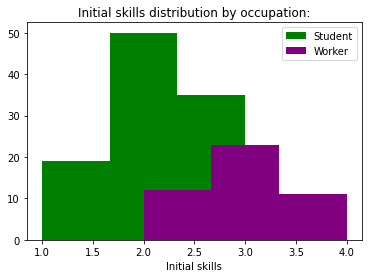

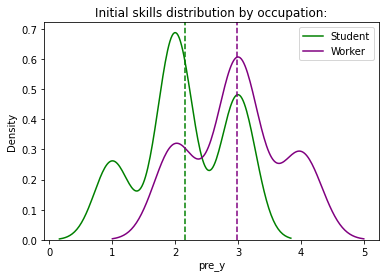

In [11]:
pyplot.title('Initial skills distribution by occupation:')
pyplot.hist(generated_data[occupation == 0].pre_y, bins = 3, color = 'green', label = 'Student')
pyplot.hist(generated_data[occupation == 1].pre_y, bins = 3, color = 'purple', label = 'Worker')
pyplot.legend()
pyplot.xlabel('Initial skills')
pyplot.show()

pyplot.title('Initial skills distribution by occupation:')
seaborn.kdeplot(generated_data[occupation == 0].pre_y, color = 'green', label = 'Student')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 0].pre_y), linestyle = 'dashed', color = 'green')
seaborn.kdeplot(generated_data[occupation == 1].pre_y, color = 'purple', label = 'Worker')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 1].pre_y), linestyle = 'dashed', color = 'purple')
pyplot.legend()
pyplot.show()

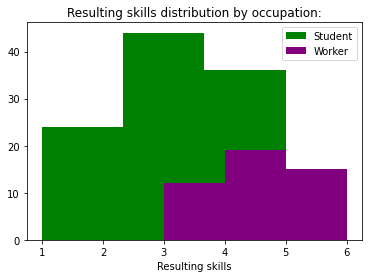

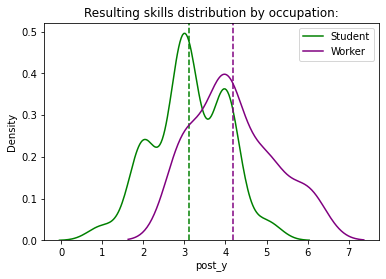

In [12]:
pyplot.title('Resulting skills distribution by occupation:')
pyplot.hist(generated_data[occupation == 0].post_y, bins = 3, color = 'green', label = 'Student')
pyplot.hist(generated_data[occupation == 1].post_y, bins = 3, color = 'purple', label = 'Worker')
pyplot.legend()
pyplot.xlabel('Resulting skills')
pyplot.show()

pyplot.title('Resulting skills distribution by occupation:')
seaborn.kdeplot(generated_data[occupation == 0].post_y, color = 'green', label = 'Student')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 0].post_y), linestyle = 'dashed', color = 'green')
seaborn.kdeplot(generated_data[occupation == 1].post_y, color = 'purple', label = 'Worker')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 1].post_y), linestyle = 'dashed', color = 'purple')
pyplot.legend()
pyplot.show()

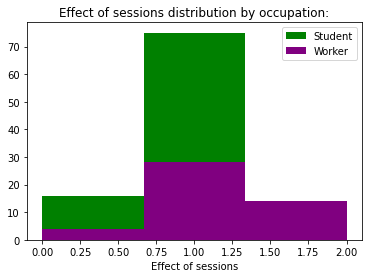

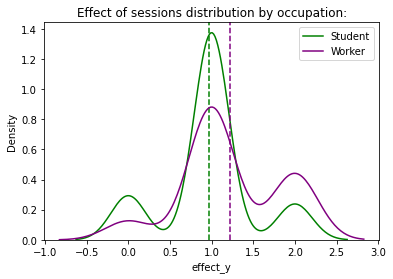

In [13]:
pyplot.title('Effect of sessions distribution by occupation:')
pyplot.hist(generated_data[occupation == 0].effect_y, bins = 3, color = 'green', label = 'Student')
pyplot.hist(generated_data[occupation == 1].effect_y, bins = 3, color = 'purple', label = 'Worker')
pyplot.legend()
pyplot.xlabel('Effect of sessions')
pyplot.show()

pyplot.title('Effect of sessions distribution by occupation:')
seaborn.kdeplot(generated_data[occupation == 0].effect_y, color = 'green', label = 'Student')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 0].effect_y), linestyle = 'dashed', color = 'green')
seaborn.kdeplot(generated_data[occupation == 1].effect_y, color = 'purple', label = 'Worker')
pyplot.axvline(x = numpy.mean(generated_data[occupation == 1].effect_y), linestyle = 'dashed', color = 'purple')
pyplot.legend()
pyplot.show()

## III. Data analysis.

### Classification of effect: support vector machines.
#### Predicting 0, 1 or 2 increase in confidence using demographics.

There are many methods of classification - however, not each one of them are:
1. Easy to interpret for the analyst and to explain to the general audience;
2. Allow to handle multiple independent variables, such as demographics measures, and stay efficient with them;
3. Versatile in allowing to transform data for better interpretability.

Thus, the method I've chosen is Support-Vector Machines - supervised (meaning requires an analyst for to provide the labels of the dependent variable) learning method that is used for a variety of tasks, including classification, regression and detection of outliers.

Support-Vector Machines are used when dealing with the data that is hard to separate with a line in a 2D space, such as 2D x-y graph. First, they map the data into multidimensional space - for example, imagine age being an x variable, occupation being a y variable, and effect of sessions being a z variable. Then, they use some kind of kernel - which is a specific mathematical function that transforms the data, maps it differently using independent variables as input and produces the output of data being transformed. The idea of kernels is that they might help transform the data in a way that will allow for easier separation - and they also help prevent overfitting of the model, meaning that the model will take into account historical data, but will not try to fit to it too closely. The resulting model will be sensitive to the past, produce a more general and, most likely, fairly accurate trend, recognizing that not all of the seen data points are located right on the trend line - some also have had randomness contributed to them.

Once the data is transformed, Support-Vector Machines separate it with one line if there are only two classes of data and multiple lines if there are more than two classes. If there is one independent variable, separation happens in 2D, if there are two - in 3D, if more - in (number of independent variables + 1) dimensions.

The separation is done by trying to find a border that will allow for the separation with minimum of data points ending up on the territory of the wrong class and is done by iteratively trying different line options to increase a distance between the "border cases" of different classes. The process can be imagined as trying to fit the border between two countries by picking cities from one side that are closest to cities on the other side, repeating the process with the other side, and then trying to find a border that would allow to separate them and maximize their equal distance to the border. The mathematical formula behind it is also easy to interpret.

In [14]:
# 1. Separate the data into training and test sets: test size can be adjusted, but I picked 50% as a baseline.
# Shuffling allows for better elimination of bias during model fitting, especially with real data.

x_train, x_test, y_train, y_test = train_test_split(x, effect_y, test_size = 0.5, shuffle = True)

# 2. Fit the models to the training data - SVC is a classis Support-Vector Machines method.
# Here I try multiple commonly used, due to their efficiency, kernels: linear, polynomial and Radial Basis Function.

linear = svm.SVC(kernel = 'linear').fit(x_train, y_train)
poly = svm.SVC(kernel = 'poly', degree = 2).fit(x_train, y_train)
rbf = svm.SVC(kernel = 'rbf').fit(x_train, y_train)

# 3. Compare the chosen models by comparing error of the performance on the training and test sets of data.
# "Score" parameter displays the accuracy of the classification of each model.
print('1.For the SVC with the linear kernel:')
print('a) Error on the training data is', 1 - linear.score(x_train, y_train))
print('b) Error on the test data is', 1 - linear.score(x_test, y_test))

print('2. For the SVC with the poly kernel of degree = 2:')
print('a) Error on the training data is', 1 - poly.score(x_train, y_train))
print('b) Error on the test data is', 1 - poly.score(x_test, y_test))

print('For the SVC with the rbf kernel:')
print('1. Error on the training data is', 1 - rbf.score(x_train, y_train))
print('2. Error on the test data is', 1 - rbf.score(x_test, y_test))

1.For the SVC with the linear kernel:
a) Error on the training data is 0.2666666666666667
b) Error on the test data is 0.36
2. For the SVC with the poly kernel of degree = 2:
a) Error on the training data is 0.2666666666666667
b) Error on the test data is 0.36
For the SVC with the rbf kernel:
1. Error on the training data is 0.2666666666666667
2. Error on the test data is 0.36


Error is provided as the proportion of data that was classified wrong when the final data separation line, the line option with the best performance, was fitted.

The expectation is that the error on the training data should not be too small in comparison to the error on the test data, as it would be an indication of the overfitting. However, in our case, the errors for training and test sets are very similar, meaning little overfitting occured.

Additionally, the error will always have some correlation to the amount of contribution of randomness or unaccounted for factors involved: since real randomness often contains no or little trend, and the mix of unaccounted for factors can have a trend that is too complex to predict due to many variables involved in a complex manner, it is hard to predict them in any systematic way. In our case of fake data, the contribution of randomness is high for both pre-sessions and post-sessions evaluation, so getting such a small error on both sets means the models were fitted well.

The reason the performance of the models with different kernels is similar is because of the simplicity of the data and absence of any specific patterns that would make one kernel more suitable for its transformation than the other ones (e.g., RBF kernel is most suitable for the chronological data).

Thus, our models can currently predict the effect of the sessions based on the demographics with 60+% accuracy; the specific value can differ if you run the full code multiple times.